When preparing data for machine learning (ML), especially for classification tasks, there are several key steps to ensure the model performs well. Here's an overview of the main things to be done:

### 1. **Data Collection**
   - Gather relevant data from various sources (databases, APIs, etc.) to ensure it is representative of the problem you want to solve.

### 2. **Data Cleaning**
   - **Handle Missing Values**: Identify and deal with missing values (e.g., remove rows, fill with mean/median/mode, or use more advanced imputation techniques).
   - **Remove Duplicates**: Check for and remove duplicate rows to avoid bias and overfitting.
   - **Correct Data Errors**: Identify and correct any errors or inconsistencies in the data (e.g., outliers, incorrect entries).

### 3. **Data Transformation**
   - **Normalization/Standardization**: Scale numeric features to a standard range (e.g., 0-1 or z-scores) to help the model learn more effectively.
   - **Encoding Categorical Variables**: Convert categorical variables into numerical form (e.g., one-hot encoding, label encoding).
   - **Feature Engineering**: Create new features from existing data that might help the model (e.g., deriving day of the week from a date).
   - **Dimensionality Reduction**: Reduce the number of features using techniques like PCA (Principal Component Analysis) to simplify the model and reduce overfitting.

### 4. **Data Splitting**
   - **Train-Test Split**: Divide the dataset into training and testing subsets (e.g., 70-30 or 80-20 split) to evaluate the model's performance on unseen data.
   - **Validation Set**: Optionally, create a separate validation set to fine-tune model hyperparameters (e.g., 60-20-20 split for train-validation-test).

### 5. **Feature Selection**
   - Identify and select the most relevant features that have the highest predictive power to reduce noise and improve model performance (e.g., using correlation, feature importance scores).

### 6. **Balancing the Dataset**
   - **Handle Imbalanced Classes**: If the dataset has imbalanced classes, apply techniques such as oversampling, undersampling, or using class weights to ensure the model doesn't become biased toward the majority class.

### 7. **Data Augmentation**
   - For small datasets, artificially increase the dataset size by creating modified versions of existing data (e.g., adding noise, transformations).

### 8. **Data Preprocessing Pipelines**
   - Automate and ensure consistency by creating preprocessing pipelines using libraries like `scikit-learn` to apply these steps systematically to the training and test data.

### 9. **Data Quality Checks**
   - Perform checks to ensure data consistency and quality throughout the preprocessing steps, such as checking distributions, correlations, and anomalies.

### 10. **Data Visualization and Analysis**
   - Use visualization techniques (like histograms, scatter plots, heatmaps) to understand the data distribution, identify patterns, detect outliers, and gain insights.

Would you like more detail on any of these steps?

## Objectives
1. To predict whether an arrest was made after a Terry Stop
2. Arrest given information about the presence of weapons
3. The time of day of the call

## Data collection

### Importing libraries

In [5]:
# import relevant libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.feature_selection import SelectFromModel 
from sklearn.linear_model import LogisticRegressionCV


### Data Understanding

In [6]:
df = pd.read_csv('Terry_Stops_20240825.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,36 - 45,-1,20160000398323,208373,Offense Report,None,4852,1953,M,Asian,...,15:18:00.0000000,TRESPASS,--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3
1,18 - 25,-1,20180000227180,559146,Citation / Infraction,None,5472,1964,M,Asian,...,00:07:00.0000000,"SUSPICIOUS PERSON, VEHICLE, OR INCIDENT",--TRAFFIC - BICYCLE VIOLATION,911,SOUTHWEST PCT - 3RD WATCH - F/W RELIEF,N,N,Southwest,F,F3
2,18 - 25,-1,20180000410091,498246,Offense Report,None,6081,1962,M,White,...,02:56:00.0000000,"NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,NORTH PCT 3RD W - BOY (JOHN) - PLATOON 1,N,N,North,B,B1
3,-,-1,20160000001637,146742,Field Contact,None,6924,1974,M,White,...,01:44:00.0000000,-,-,-,EAST PCT OPS - NIGHT ACT,N,N,East,C,C1
4,46 - 55,-1,20150000006037,104477,Field Contact,None,6732,1975,M,White,...,02:59:00.0000000,-,-,-,SOUTH PCT 3RD W - SAM - PLATOON 2,N,N,North,B,B2


In [7]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat'],
      dtype='object')

In [8]:
#checking data  shape
df.shape
print('Number of rows =', df.shape[0])
print('Number of columns =', df.shape[1])

Number of rows = 61009
Number of columns = 23


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61009 entries, 0 to 61008
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         61009 non-null  object
 1   Subject ID                61009 non-null  int64 
 2   GO / SC Num               61009 non-null  int64 
 3   Terry Stop ID             61009 non-null  int64 
 4   Stop Resolution           61009 non-null  object
 5   Weapon Type               61009 non-null  object
 6   Officer ID                61009 non-null  object
 7   Officer YOB               61009 non-null  int64 
 8   Officer Gender            61009 non-null  object
 9   Officer Race              61009 non-null  object
 10  Subject Perceived Race    61009 non-null  object
 11  Subject Perceived Gender  61009 non-null  object
 12  Reported Date             61009 non-null  object
 13  Reported Time             61009 non-null  object
 14  Initial Call Type     

## Checking for null values

In [10]:
df.isnull().sum()

Subject Age Group             0
Subject ID                    0
GO / SC Num                   0
Terry Stop ID                 0
Stop Resolution               0
Weapon Type                   0
Officer ID                    0
Officer YOB                   0
Officer Gender                0
Officer Race                  0
Subject Perceived Race        0
Subject Perceived Gender      0
Reported Date                 0
Reported Time                 0
Initial Call Type             0
Final Call Type               0
Call Type                     0
Officer Squad               561
Arrest Flag                   0
Frisk Flag                    0
Precinct                      0
Sector                        0
Beat                          0
dtype: int64

The dataset contains a significant number of NaN values relative to its size (61,009 entries).

    The output indicates the count of missing values (NaN or null values) for each column in the dataset:

    officer squad has 561 missing values.

In [11]:
def missing_data(df, column):
    length_of_df=len(df)                                                    
    missing_data= column.isna().sum()                                       
    percentage_of_missing_data = round((missing_data/length_of_df*100),2)   
    return print(f"Percentage of Missing Data: {percentage_of_missing_data}""%")

In [12]:
missing_data(df,df['Officer Squad'])

Percentage of Missing Data: 0.92%


In [13]:
# Function to replace nulls in officer squad column with the mode of officer squad for the same precinct
def replace_null_with_mode(df, target_col, group_col):
    # Iterating through the rows with null values in the target column
    for index, row in df[df[target_col].isnull()].iterrows():
        # Getting the corresponding group value (zipcode)
        group_value = row[group_col]
        # Filtering the DataFrame to include only rows with the same group value and non-null target values
        filtered_df = df[(df[group_col] == group_value) & df[target_col].notnull()]
        # Getting the mode of the target column in the filtered DataFrame
        mode_value = filtered_df[target_col].mode()
        # Checking if mode_value is not empty
        if not mode_value.empty:
            # Replacing the null value with the mode value
            df.at[index, target_col] = mode_value[0]
    return df

# Replacing nulls in officer squad with the mode of officer squad for the same precinct
df = replace_null_with_mode(df, 'Officer Squad', 'Precinct')


In [14]:
df.isna().sum()

Subject Age Group           0
Subject ID                  0
GO / SC Num                 0
Terry Stop ID               0
Stop Resolution             0
Weapon Type                 0
Officer ID                  0
Officer YOB                 0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Reported Date               0
Reported Time               0
Initial Call Type           0
Final Call Type             0
Call Type                   0
Officer Squad               0
Arrest Flag                 0
Frisk Flag                  0
Precinct                    0
Sector                      0
Beat                        0
dtype: int64

### Checking for duplicates

In [15]:
df.duplicated().sum()

0

### Further exploration

In [16]:
df['Frisk Flag'].value_counts()

N    45931
Y    14600
-      478
Name: Frisk Flag, dtype: int64

In [17]:
df['Frisk Flag'].replace(to_replace=['N', '-', 'Y'], value=[0, 0, 1], inplace=True)

In [18]:
df['Frisk Flag'].value_counts()

0    46409
1    14600
Name: Frisk Flag, dtype: int64

In this case 1 shows whether a frisk was done while 0 is that none was done.

In [21]:
df['Arrest Flag'].value_counts()

N    54427
Y     6582
Name: Arrest Flag, dtype: int64

## Visualization of relationship

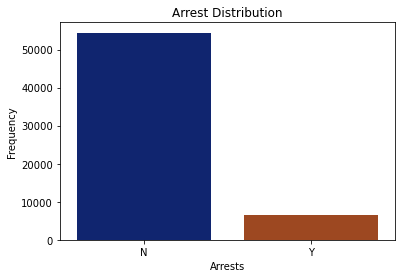

N    54427
Y     6582
Name: Arrest Flag, dtype: int64


In [22]:
# Distribution of Churn
sns.countplot(x='Arrest Flag', data=df, palette='dark')
plt.title('Arrest Distribution')
plt.xlabel('Arrests')
plt.ylabel('Frequency')
plt.show()

print(df['Arrest Flag'].value_counts())

>From the above plot the number of arrests made were few after a terry stop

In [ ]:
#total charge of calls per area code

# Create subplots for each variable
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot histograms for each variable
axs[0].hist(df['total day minutes'], bins=20, edgecolor='k')
axs[0].set_title('Total day minutes')
axs[0].set_xlabel('Minutes')
axs[0].set_ylabel('Frequency')

axs[1].hist(df['total eve minutes'], bins=20, edgecolor='k')
axs[1].set_title('Total evening minutes')
axs[1].set_xlabel('Minutes')
axs[1].set_ylabel('Frequency')

axs[2].hist(df.['total night minutes'], bins=20, edgecolor='k')
axs[2].set_title('Total night minutes')
axs[2].set_xlabel('Minutes')
axs[2].set_ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## Data splitting


In [ ]:
X1 = None
y1 = None

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.2,random_state=42)

TypeError: Expected sequence or array-like, got <class 'NoneType'>